In [27]:
%load_ext autoreload
%autoreload 2

from spear.assets import Asset
from spear.events import Action, Event
from spear.flows import Expense, TaxableIncome
from spear.model import FinancialModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
salary = TaxableIncome(name="Salary", initial_value=310_000, state="MA")
housing = Expense(name="Housing", initial_value=40_000, inflation_rate=0.02)
cost_of_living = Expense(name="Cost of Living", initial_value=50_000, inflation_rate=0.03)
health_insurance = Expense(name="Health Insurance", initial_value=0, inflation_rate=0.03)
mortgage = Expense(name="Mortgage", initial_value=0, inflation_rate=0.0)

cash = Asset(name="Cash", initial_value=50_000, growth_rate=0.01, cap_value=50_000)
bonds = Asset(name="Bonds", initial_value=50_000, growth_rate=0.03, allocation=0.1)
stocks = Asset(
    name="Stocks",
    initial_value=380_000,
    growth_rate=0.08,
    allocation=0.9,
    monte_carlo=False,
    seed=42,
)
_401k = Asset(
    name="401k",
    initial_value=250_000,
    growth_rate=0.08,
    cap_deposit=46_000,
    pretax=True,
    monte_carlo=False,
    seed=42,
)

In [102]:
# Salary goes to 0
# Health insurance increases by 3000/person per year (2200/year in tax penalties for not having insurance, 400/yr in annual physical and tests, 600 buffer)
quit_job = Event(
    name="Quit Job",
    year=2029,
    actions=[
        Action(
            target=salary,
            action="update_base_value",
            params={"base_value": 0, "duration": 100},
        ),
        Action(
            target=health_insurance,
            action="update_base_value",
            params={"base_value": 6_000, "duration": 100},
        ),
    ],
)

In [103]:
# Event: buy house
# Investment goes down by down payment (incl fees)
# Note: the 200k for house down payment needs to be invested otherwise it’ll always look like buying a house is better bc oppty cost of investing the down payment is not reflected
# Housing cost goes to 10k/year (house insurance, maintenance) + annual mortgage

house_price = 600_000
downpayment = max(0.2 * house_price, 200_000)
loaned_amount = house_price - downpayment

def get_monthly_mortgage(loaned_amount: float, interest_rate: float, years: int) -> float:
    n = years * 12
    r = interest_rate / 12
    return loaned_amount * (r * (1 + r) ** n) / ((1 + r) ** n - 1)

def get_annual_mortgage(monthly_mortgage: float) -> float:
    return monthly_mortgage * 12

yearly_mortgage = get_annual_mortgage(get_monthly_mortgage(loaned_amount, 0.07, 30))

buy_house = Event(
    name="Buy House",
    year=2026,
    actions=[
        Action(target=stocks, action="withdraw", params={"amount": 200_000}),
        Action(target=housing, action="update_base_value", params={"base_value": 10_000, "duration": 100}),
        Action(target=mortgage, action="update_base_value", params={"base_value": yearly_mortgage, "duration": 30}),
    ],
)


In [106]:
#Event: stop investing in 401k
#Allocation to 401k goes to 0
#Salary goes up by 401k minus taxes

stop_investing_in_401k = Event(
    name="Stop Investing in 401k",
    year=2025,
    actions=[
        Action(target=_401k, action="update_cap_deposit", params={"cap_deposit": 0}),
        Action(target=salary, action="add_to_base_value", params={"base_value": _401k.cap_deposit, "duration": 100}),
    ],
)

In [107]:
kobald_ipos = Event(
    name="Kobald Ipos",
    year=2028,
    actions=[Action(target=salary, action="add_to_base_value", params={"base_value": 900_000})],
)

In [108]:
planner = FinancialModel(
    revenues=[salary],
    expenses=[housing, cost_of_living, health_insurance],
    assets=[cash, bonds, stocks, _401k],
    events=[quit_job, buy_house, kobald_ipos, stop_investing_in_401k],
    duration=30,
    # enable_logging=True,
)
planner.run()

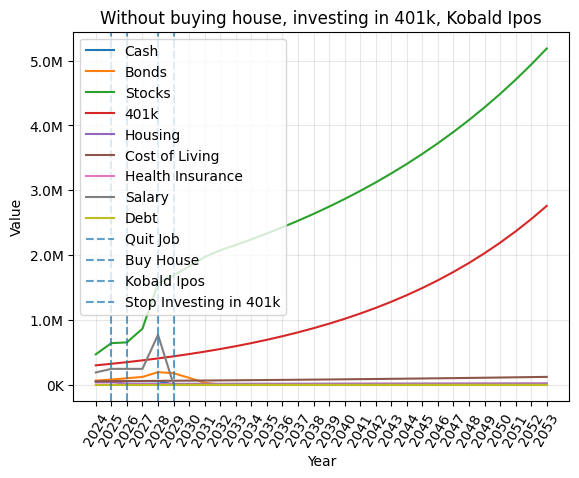

In [109]:
ax = planner.plot_all();
ax.set(title="Without buying house, investing in 401k, Kobald Ipos");

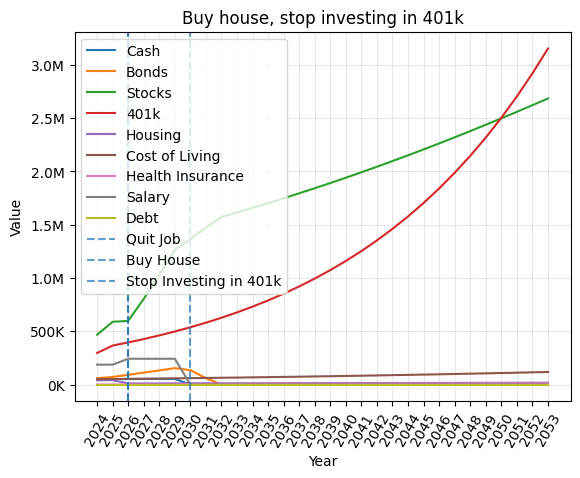

In [97]:
ax = planner.plot_all();
ax.set(title="Buy house, stop investing in 401k");

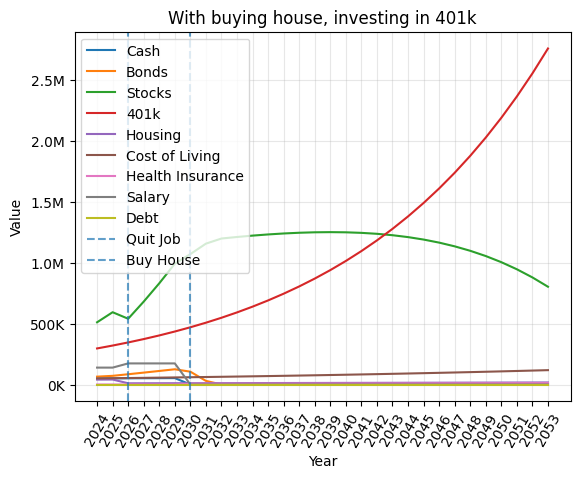

In [99]:
ax = planner.plot_all();
ax.set(title="With buying house, investing in 401k");

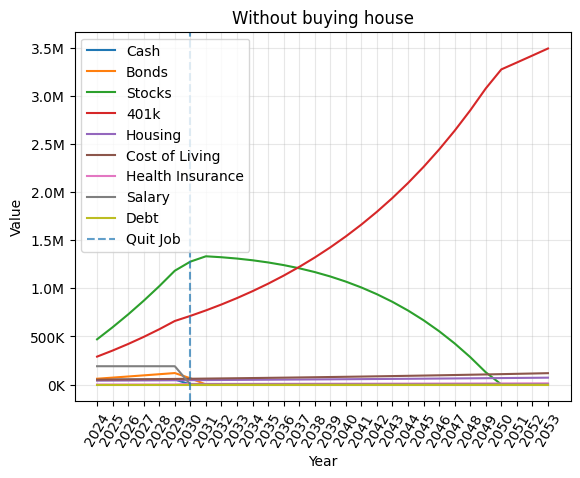

In [63]:
ax = planner.plot_all();
ax.set(title="Without buying house");